# Takeaways
- Maintain separate payloads for api vs. mobile
    - Faster to read/write .parquet + .npy, but only api can use those
    - Mobile needs to use .sqlite + files (.png, .mp4), but it's slower for both read and write
- TODO Still more room to compress mobile payloads
    - 71% of payload: audio
        - Can be cut in ~half if we can drop 32k -> 16k (maybe with aac_he?)
            - Android supports HE-AACv2: https://developer.android.com/guide/topics/media/media-formats
            - But ios doesn't? https://apple.co/2NORQHB
        - Payload 1.98g -> ~1.28g -- ✅ ~35% of payload
    - 21% of payload: spectro
        - Not much excess: maybe ~5% of spectros (see notebooks/spectro_img_encode)
        - Payload 1.98g -> ~1.96g -- ❌ ~1% of payload
    - 5.9% of payload: f_preds_* sqlite cols (n_sp=331)
        - (Based on: 119m = 164m with - 45m without)
        - No float32 in sqlite, only float64 [❓ Unless we get clever and pack into int32/int16, or blob...]
            - [e.g. blob: https://github.com/SeanTater/sqlite3-extras]
        - Can pca compress, but can't achieve more than a few % of payload
        - Payload 1.98g -> ~1.98g with n_components=331 -- min ~0% of payload
        - Payload 1.98g -> ~1.93g with n_components=150 --  🔶 ~3% of payload
        - Payload 1.98g -> ~1.90g with n_components=100 --  🔶 ~4% of payload
        - Payload 1.98g -> ~1.86g with n_components=10  --  🔶 ~6% of payload
        - Payload 1.98g -> ~1.86g with n_components=0   -- max ~6% of payload
    - 2.2% of payload: rest of sqlite cols
        - Max ~2% of payload -- ❌ low ROI

In [ ]:
from notebooks import *
sg.init(None, skip=[sg_load.load_search_recs])
get_search_recs.cache_clear()

INFO     [17:58:07.963] [26643] 150 logging_/<module>: {logging_yaml: None}

INFO     [17:58:08.400] [26643]  32 api.server_globals/init

DEBUG    [17:58:08.407] [26643]  75 api.server_globals/load: load_search...

INFO     [17:58:08.790] [26643]  79 api.server_globals/load: load_search (took 0.376s)

DEBUG    [17:58:08.798] [26643]  75 api.server_globals/load: load_xc_meta...

INFO     [17:58:09.222] [26643]  79 api.server_globals/load: load_xc_meta (took 0.418s)

DEBUG    [17:58:09.229] [26643]  75 api.server_globals/load: load_feat_info...

INFO     [17:58:09.235] [26643] 110 api.server_globals/load_feat_info

INFO     [17:58:09.242] [26643]  79 api.server_globals/load: load_feat_info (took 0.007s)

WARNING  [17:58:09.249] [26643]  73 api.server_globals/load: load_search_recs [skipped]

INFO     [17:58:09.256] [26643]  34 api.server_globals/init: done

# Perf notes

Before
- Cold cache (warm pagecache but cold python proc)
```
search_recs(**{'cache_type': 'hybrid'})
...
DEBUG    [12:58:26.994] [37904] 119 payloads/df_cache_hybrid: Hit [start]
DEBUG    [12:58:27.001] [37904] 129 payloads/df_cache_hybrid: Hit: Reading non_feats.parquet (1.8 GB)
INFO     [12:58:32.028] [37904] 136 payloads/df_cache_hybrid: Hit: Read non_feats.parquet (1.8 GB)
DEBUG    [12:58:32.040] [37904] 141 payloads/df_cache_hybrid: Hit: Reading feat-f_preds.npy (46.6 MB)
INFO     [12:58:32.077] [37904] 143 payloads/df_cache_hybrid: Hit: Read feat-f_preds.npy: float32 (46.6 MB)
DEBUG    [12:58:32.084] [37904] 141 payloads/df_cache_hybrid: Hit: Reading feat-feat.npy (211.4 MB)
INFO     [12:58:32.211] [37904] 143 payloads/df_cache_hybrid: Hit: Read feat-feat.npy: float32 (211.4 MB)
INFO     [12:58:32.218] [37904] 147 payloads/df_cache_hybrid: Hit: Join non_feats + feats
INFO     [12:58:32.469] [37904] 155 payloads/df_cache_hybrid: Hit [5.475s]
```

search_recs(**{'cache_type': 'hybrid'})

INFO     [17:58:09.429] [26643] 601 api.recs/get_search_recs

INFO     [17:58:09.445] [26643]  77 payloads/df_cache_hybrid: Miss: payloads/search_recs-version[7],limit[3500],audio_s[10],countries_k[na],com_names_k[ca],num_recs[None]-b68f105

INFO     [17:58:09.458] [26643] 659 api.recs/_compute_search_recs: {len(sg.xc_meta): 35233, countries_k: na, com_names_k: ca, num_recs: null}

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.4s

f_preds: [

#######################################################################################

] | 100% (500) |  0.5s

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:  11%|██████▊                                                      | 56/500 [00:00<00:00, 553.79it/s]

rec_spectro_bytes:  22%|█████████████▍                                              | 112/500 [00:00<00:00, 554.91it/s]

rec_spectro_bytes:  34%|████████████████████▎                                       | 169/500 [00:00<00:00, 558.54it/s]

rec_spectro_bytes:  45%|███████████████████████████                                 | 226/500 [00:00<00:00, 558.83it/s]

rec_spectro_bytes:  57%|█████████████████████████████████▉                          | 283/500 [00:00<00:00, 560.36it/s]

rec_spectro_bytes:  67%|████████████████████████████████████████▏                   | 335/500 [00:00<00:00, 553.00it/s]

rec_spectro_bytes:  78%|██████████████████████████████████████████████▌             | 388/500 [00:00<00:00, 549.49it/s]

rec_spectro_bytes:  89%|█████████████████████████████████████████████████████▏      | 443/500 [00:00<00:00, 549.50it/s]

rec_spectro_bytes: 100%|███████████████████████████████████████████████████████████▉| 499/500 [00:00<00:00, 550.31it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 549.01it/s]

INFO     [17:58:12.430] [26643] 925 api.recs/recs_featurize_spectro_bytes: [0.919s]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

#########################################################                          

] |  69% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [17:58:12.679] [26643] 999 api.recs/recs_featurize_audio_bytes: [0.236s]

INFO     [17:58:12.689] [26643] 687 api.recs/recs_featurize_pre_rank: batches (1/7) [3.215s]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   6%|███▋                                                         | 30/500 [00:00<00:01, 291.99it/s]

rec_spectro_bytes:  13%|███████▊                                                     | 64/500 [00:00<00:01, 311.02it/s]

rec_spectro_bytes:  19%|███████████▋                                                 | 96/500 [00:00<00:01, 311.45it/s]

rec_spectro_bytes:  25%|███████████████▏                                            | 127/500 [00:00<00:01, 309.22it/s]

rec_spectro_bytes:  32%|███████████████████▏                                        | 160/500 [00:00<00:01, 311.75it/s]

rec_spectro_bytes:  39%|███████████████████████▏                                    | 193/500 [00:00<00:00, 313.36it/s]

rec_spectro_bytes:  45%|███████████████████████████                                 | 226/500 [00:00<00:00, 314.75it/s]

rec_spectro_bytes:  51%|██████████████████████████████▊                             | 257/500 [00:00<00:00, 313.43it/s]

rec_spectro_bytes:  57%|██████████████████████████████████▍                         | 287/500 [00:00<00:00, 311.82it/s]

rec_spectro_bytes:  64%|██████████████████████████████████████▎                     | 319/500 [00:01<00:00, 312.45it/s]

rec_spectro_bytes:  70%|██████████████████████████████████████████                  | 350/500 [00:01<00:00, 312.12it/s]

rec_spectro_bytes:  77%|██████████████████████████████████████████████              | 384/500 [00:01<00:00, 313.88it/s]

rec_spectro_bytes:  84%|██████████████████████████████████████████████████▍         | 420/500 [00:01<00:00, 316.99it/s]

rec_spectro_bytes:  91%|██████████████████████████████████████████████████████▋     | 456/500 [00:01<00:00, 319.39it/s]

rec_spectro_bytes:  99%|███████████████████████████████████████████████████████████▏| 493/500 [00:01<00:00, 322.37it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 322.51it/s]

INFO     [17:58:14.801] [26643] 925 api.recs/recs_featurize_spectro_bytes: [1.560s]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

###################################################                                

] |  61% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [17:58:15.049] [26643] 999 api.recs/recs_featurize_audio_bytes: [0.235s]

INFO     [17:58:15.060] [26643] 687 api.recs/recs_featurize_pre_rank: batches (2/7) [2.360s]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████                                                         | 33/500 [00:00<00:01, 322.51it/s]

rec_spectro_bytes:  14%|████████▎                                                    | 68/500 [00:00<00:01, 334.59it/s]

rec_spectro_bytes:  21%|████████████▋                                               | 106/500 [00:00<00:01, 347.57it/s]

rec_spectro_bytes:  29%|█████████████████▎                                          | 144/500 [00:00<00:01, 354.22it/s]

rec_spectro_bytes:  36%|█████████████████████▊                                      | 182/500 [00:00<00:00, 358.62it/s]

rec_spectro_bytes:  44%|██████████████████████████▍                                 | 220/500 [00:00<00:00, 361.95it/s]

rec_spectro_bytes:  52%|██████████████████████████████▉                             | 258/500 [00:00<00:00, 363.23it/s]

rec_spectro_bytes:  59%|███████████████████████████████████▋                        | 297/500 [00:00<00:00, 365.47it/s]

rec_spectro_bytes:  67%|████████████████████████████████████████                    | 334/500 [00:00<00:00, 365.11it/s]

rec_spectro_bytes:  74%|████████████████████████████████████████████▍               | 370/500 [00:01<00:00, 363.37it/s]

rec_spectro_bytes:  81%|████████████████████████████████████████████████▋           | 406/500 [00:01<00:00, 360.72it/s]

rec_spectro_bytes:  88%|█████████████████████████████████████████████████████       | 442/500 [00:01<00:00, 359.69it/s]

rec_spectro_bytes:  95%|█████████████████████████████████████████████████████████▏  | 477/500 [00:01<00:00, 358.09it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 357.10it/s]

INFO     [17:58:17.032] [26643] 925 api.recs/recs_featurize_spectro_bytes: [1.408s]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

############################################                                       

] |  53% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [17:58:17.280] [26643] 999 api.recs/recs_featurize_audio_bytes: [0.234s]

INFO     [17:58:17.290] [26643] 687 api.recs/recs_featurize_pre_rank: batches (3/7) [2.218s]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████                                                         | 33/500 [00:00<00:01, 328.58it/s]

rec_spectro_bytes:  13%|████████▏                                                    | 67/500 [00:00<00:01, 333.41it/s]

rec_spectro_bytes:  20%|████████████                                                 | 99/500 [00:00<00:01, 327.30it/s]

rec_spectro_bytes:  27%|███████████████▉                                            | 133/500 [00:00<00:01, 328.77it/s]

rec_spectro_bytes:  34%|████████████████████▎                                       | 169/500 [00:00<00:00, 334.23it/s]

rec_spectro_bytes:  41%|████████████████████████▎                                   | 203/500 [00:00<00:00, 335.03it/s]

rec_spectro_bytes:  48%|████████████████████████████▌                               | 238/500 [00:00<00:00, 336.11it/s]

rec_spectro_bytes:  55%|█████████████████████████████████                           | 275/500 [00:00<00:00, 339.41it/s]

rec_spectro_bytes:  62%|█████████████████████████████████████▎                      | 311/500 [00:00<00:00, 341.42it/s]

rec_spectro_bytes:  70%|█████████████████████████████████████████▉                  | 349/500 [00:01<00:00, 345.00it/s]

rec_spectro_bytes:  77%|██████████████████████████████████████████████              | 384/500 [00:01<00:00, 344.88it/s]

rec_spectro_bytes:  84%|██████████████████████████████████████████████████▎         | 419/500 [00:01<00:00, 342.65it/s]

rec_spectro_bytes:  91%|██████████████████████████████████████████████████████▎     | 453/500 [00:01<00:00, 341.48it/s]

rec_spectro_bytes:  97%|██████████████████████████████████████████████████████████▍ | 487/500 [00:01<00:00, 340.29it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 339.74it/s]

INFO     [17:58:19.334] [26643] 925 api.recs/recs_featurize_spectro_bytes: [1.480s]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

####################################################                               

] |  62% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [17:58:19.586] [26643] 999 api.recs/recs_featurize_audio_bytes: [0.240s]

INFO     [17:58:19.596] [26643] 687 api.recs/recs_featurize_pre_rank: batches (4/7) [2.294s]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.4s

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▍                                                        | 36/500 [00:00<00:01, 351.57it/s]

rec_spectro_bytes:  14%|████████▋                                                    | 71/500 [00:00<00:01, 349.64it/s]

rec_spectro_bytes:  21%|████████████▋                                               | 106/500 [00:00<00:01, 347.80it/s]

rec_spectro_bytes:  28%|████████████████▊                                           | 140/500 [00:00<00:01, 344.10it/s]

rec_spectro_bytes:  34%|████████████████████▋                                       | 172/500 [00:00<00:00, 338.76it/s]

rec_spectro_bytes:  42%|████████████████████████▉                                   | 208/500 [00:00<00:00, 340.37it/s]

rec_spectro_bytes:  48%|█████████████████████████████                               | 242/500 [00:00<00:00, 339.29it/s]

rec_spectro_bytes:  55%|█████████████████████████████████                           | 276/500 [00:00<00:00, 339.01it/s]

rec_spectro_bytes:  62%|█████████████████████████████████████▎                      | 311/500 [00:00<00:00, 340.14it/s]

rec_spectro_bytes:  69%|█████████████████████████████████████████▌                  | 346/500 [00:01<00:00, 340.38it/s]

rec_spectro_bytes:  76%|█████████████████████████████████████████████▌              | 380/500 [00:01<00:00, 338.86it/s]

rec_spectro_bytes:  83%|█████████████████████████████████████████████████▌          | 413/500 [00:01<00:00, 336.75it/s]

rec_spectro_bytes:  89%|█████████████████████████████████████████████████████▋      | 447/500 [00:01<00:00, 336.49it/s]

rec_spectro_bytes:  96%|█████████████████████████████████████████████████████████▌  | 480/500 [00:01<00:00, 333.50it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 332.38it/s]

INFO     [17:58:21.673] [26643] 925 api.recs/recs_featurize_spectro_bytes: [1.513s]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

###################################################                                

] |  61% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [17:58:21.920] [26643] 999 api.recs/recs_featurize_audio_bytes: [0.234s]

INFO     [17:58:21.929] [26643] 687 api.recs/recs_featurize_pre_rank: batches (5/7) [2.323s]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.1s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

#######################################################################################

] | 100% (500) |  0.3s

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   6%|███▍                                                         | 28/500 [00:00<00:01, 274.98it/s]

rec_spectro_bytes:   9%|█████▋                                                       | 47/500 [00:00<00:01, 232.59it/s]

rec_spectro_bytes:  14%|████████▋                                                    | 71/500 [00:00<00:01, 234.32it/s]

rec_spectro_bytes:  20%|████████████                                                 | 99/500 [00:00<00:01, 245.12it/s]

rec_spectro_bytes:  27%|████████████████▍                                           | 137/500 [00:00<00:01, 265.56it/s]

rec_spectro_bytes:  35%|████████████████████▉                                       | 174/500 [00:00<00:01, 281.32it/s]

rec_spectro_bytes:  42%|█████████████████████████▎                                  | 211/500 [00:00<00:00, 293.38it/s]

rec_spectro_bytes:  50%|█████████████████████████████▉                              | 249/500 [00:00<00:00, 303.06it/s]

rec_spectro_bytes:  56%|█████████████████████████████████▊                          | 282/500 [00:00<00:00, 304.34it/s]

rec_spectro_bytes:  64%|██████████████████████████████████████▌                     | 321/500 [00:01<00:00, 312.03it/s]

rec_spectro_bytes:  72%|███████████████████████████████████████████                 | 359/500 [00:01<00:00, 317.58it/s]

rec_spectro_bytes:  80%|███████████████████████████████████████████████▊            | 398/500 [00:01<00:00, 322.78it/s]

rec_spectro_bytes:  87%|████████████████████████████████████████████████████▏       | 435/500 [00:01<00:00, 325.72it/s]

rec_spectro_bytes:  95%|████████████████████████████████████████████████████████▊   | 473/500 [00:01<00:00, 329.29it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 330.45it/s]

INFO     [17:58:24.013] [26643] 925 api.recs/recs_featurize_spectro_bytes: [1.521s]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

#############################################                                      

] |  55% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [17:58:24.262] [26643] 999 api.recs/recs_featurize_audio_bytes: [0.237s]

INFO     [17:58:24.270] [26643] 687 api.recs/recs_featurize_pre_rank: batches (6/7) [2.331s]

f_preds: [

] |   0% (500) |  0.0s

f_preds: [

] |   0% (500) |  0.2s

f_preds: [

] |   0% (500) |  0.3s

f_preds: [

#######################################################################################

] | 100% (500) |  0.4s

rec_spectro_bytes:   0%|                                                                       | 0/500 [00:00<?, ?it/s]

rec_spectro_bytes:   7%|████▌                                                        | 37/500 [00:00<00:01, 361.80it/s]

rec_spectro_bytes:  15%|█████████▏                                                   | 75/500 [00:00<00:01, 368.88it/s]

rec_spectro_bytes:  23%|█████████████▌                                              | 113/500 [00:00<00:01, 372.51it/s]

rec_spectro_bytes:  30%|█████████████████▊                                          | 148/500 [00:00<00:00, 365.38it/s]

rec_spectro_bytes:  36%|█████████████████████▌                                      | 180/500 [00:00<00:00, 355.81it/s]

rec_spectro_bytes:  43%|█████████████████████████▋                                  | 214/500 [00:00<00:00, 352.13it/s]

rec_spectro_bytes:  50%|██████████████████████████████                              | 251/500 [00:00<00:00, 353.47it/s]

rec_spectro_bytes:  57%|██████████████████████████████████▏                         | 285/500 [00:00<00:00, 351.12it/s]

rec_spectro_bytes:  64%|██████████████████████████████████████▍                     | 320/500 [00:00<00:00, 350.13it/s]

rec_spectro_bytes:  71%|██████████████████████████████████████████▎                 | 353/500 [00:01<00:00, 346.44it/s]

rec_spectro_bytes:  77%|██████████████████████████████████████████████▎             | 386/500 [00:01<00:00, 344.17it/s]

rec_spectro_bytes:  84%|██████████████████████████████████████████████████▍         | 420/500 [00:01<00:00, 343.51it/s]

rec_spectro_bytes:  91%|██████████████████████████████████████████████████████▍     | 454/500 [00:01<00:00, 343.15it/s]

rec_spectro_bytes:  98%|██████████████████████████████████████████████████████████▌ | 488/500 [00:01<00:00, 341.48it/s]

rec_spectro_bytes: 100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 341.19it/s]

INFO     [17:58:26.395] [26643] 925 api.recs/recs_featurize_spectro_bytes: [1.474s]

audio_bytes: [

] |   0% (500) |  0.0s

audio_bytes: [

#######################################                                            

] |  47% (500) |  0.1s

audio_bytes: [

###################################################################################

] | 100% (500) |  0.2s

INFO     [17:58:26.640] [26643] 999 api.recs/recs_featurize_audio_bytes: [0.232s]

INFO     [17:58:26.651] [26643] 687 api.recs/recs_featurize_pre_rank: batches (7/7) [2.367s]

INFO     [17:58:26.716] [26643]  83 payloads/df_cache_hybrid: Compute: search_recs [17.258s]

INFO     [17:58:26.742] [26643] 101 payloads/df_cache_hybrid: Miss: Inferred feat_cols['f_preds', 'feat']

INFO     [17:58:27.487] [26643] 109 payloads/df_cache_hybrid: Miss: Write api/lite.parquet [4.9 MB, 0.731s]

INFO     [17:58:28.129] [26643] 118 payloads/df_cache_hybrid: Miss: Write api/bytes-audio_bytes.parquet [142.0 MB, 0.627s]

INFO     [17:58:28.291] [26643] 118 payloads/df_cache_hybrid: Miss: Write api/bytes-spectro_bytes.parquet [38.5 MB, 0.148s]

INFO     [17:58:28.315] [26643] 125 payloads/df_cache_hybrid: Miss: Write api/feat-f_preds.npy: float32 [4.6 MB, 0.005s]

INFO     [17:58:28.379] [26643] 125 payloads/df_cache_hybrid: Miss: Write api/feat-feat.npy: float32 [21.0 MB, 0.045s]

INFO     [17:58:28.387] [26643] 143 payloads/df_cache_hybrid: Miss: search_recs [1.661s]

Mobile: Ensure dirs: audio_bytes: [

] |   0% (305) |  0.0s

Mobile: Ensure dirs: audio_bytes: [

##############################################################

] | 100% (305) |  0.1s

Mobile: Write files: audio_bytes: [

] |   0% (3500) |  0.0s

Mobile: Write files: audio_bytes: [

] |   0% (3500) |  0.1s

Mobile: Write files: audio_bytes: [

#####                                                        

] |   8% (3500) |  0.2s

Mobile: Write files: audio_bytes: [

############                                                 

] |  20% (3500) |  0.3s

Mobile: Write files: audio_bytes: [

############                                                 

] |  20% (3500) |  0.5s

Mobile: Write files: audio_bytes: [

########################                                     

] |  40% (3500) |  0.6s

Mobile: Write files: audio_bytes: [

########################                                     

] |  40% (3500) |  0.7s

Mobile: Write files: audio_bytes: [

####################################                         

] |  60% (3500) |  0.8s

Mobile: Write files: audio_bytes: [

####################################                         

] |  60% (3500) |  0.9s

Mobile: Write files: audio_bytes: [

################################################             

] |  80% (3500) |  1.0s

Mobile: Write files: audio_bytes: [

################################################             

] |  80% (3500) |  1.2s

Mobile: Write files: audio_bytes: [

#############################################################

] | 100% (3500) |  1.3s

Mobile: Ensure dirs: spectro_bytes: [

] |   0% (305) |  0.0s

Mobile: Ensure dirs: spectro_bytes: [

############################################################

] | 100% (305) |  0.1s

Mobile: Write files: spectro_bytes: [

] |   0% (3500) |  0.0s

Mobile: Write files: spectro_bytes: [

] |   0% (3500) |  0.1s

Mobile: Write files: spectro_bytes: [

###########                                                

] |  20% (3500) |  0.2s

Mobile: Write files: spectro_bytes: [

#######################                                    

] |  40% (3500) |  0.3s

Mobile: Write files: spectro_bytes: [

#######################                                    

] |  40% (3500) |  0.5s

Mobile: Write files: spectro_bytes: [

###################################                        

] |  60% (3500) |  0.6s

Mobile: Write files: spectro_bytes: [

###############################################            

] |  80% (3500) |  0.7s

Mobile: Write files: spectro_bytes: [

###########################################################

] | 100% (3500) |  0.8s

INFO     [17:58:32.753] [26643] 274 payloads/df_cache_hybrid: Mobile: Expand feat col: f_preds (331) [0.488s]

INFO     [17:58:32.805] [26643] 307 payloads/<dictcomp>: Mobile: Covert non-sql col: json_dumps_canonical(background) (3500) [0.017s]

INFO     [17:58:32.834] [26643] 307 payloads/<dictcomp>: Mobile: Covert non-sql col: json_dumps_canonical(background_species) (3500) [0.016s]

INFO     [17:58:34.675] [26643] 320 payloads/df_cache_hybrid: Mobile: Write mobile-version[0]/search_recs/search_recs.sqlite3 [15.3 MB, 1.821s]

INFO     [17:58:34.696] [26643] 320 payloads/df_cache_hybrid: Mobile: Write payload [6.298s]

,dir,file,size,frac
5,api,TOTAL,210989577,1.000
1,api,api/bytes-audio_bytes.parquet,142018687,0.673
2,api,api/bytes-spectro_bytes.parquet,38468688,0.182
4,api,api/feat-feat.npy: float32,21000128,0.100
0,api,api/lite.parquet,4867946,0.023
3,api,api/feat-f_preds.npy: float32,4634128,0.022
9,mobile-version[0],TOTAL,211288064,1.000
6,mobile-version[0],mobile-version[0]/search_recs/audio/,150949888,0.714
7,mobile-version[0],mobile-version[0]/search_recs/spectro/,45084672,0.213
8,mobile-version[0],mobile-version[0]/search_recs/search_recs.sqlite3,15253504,0.072


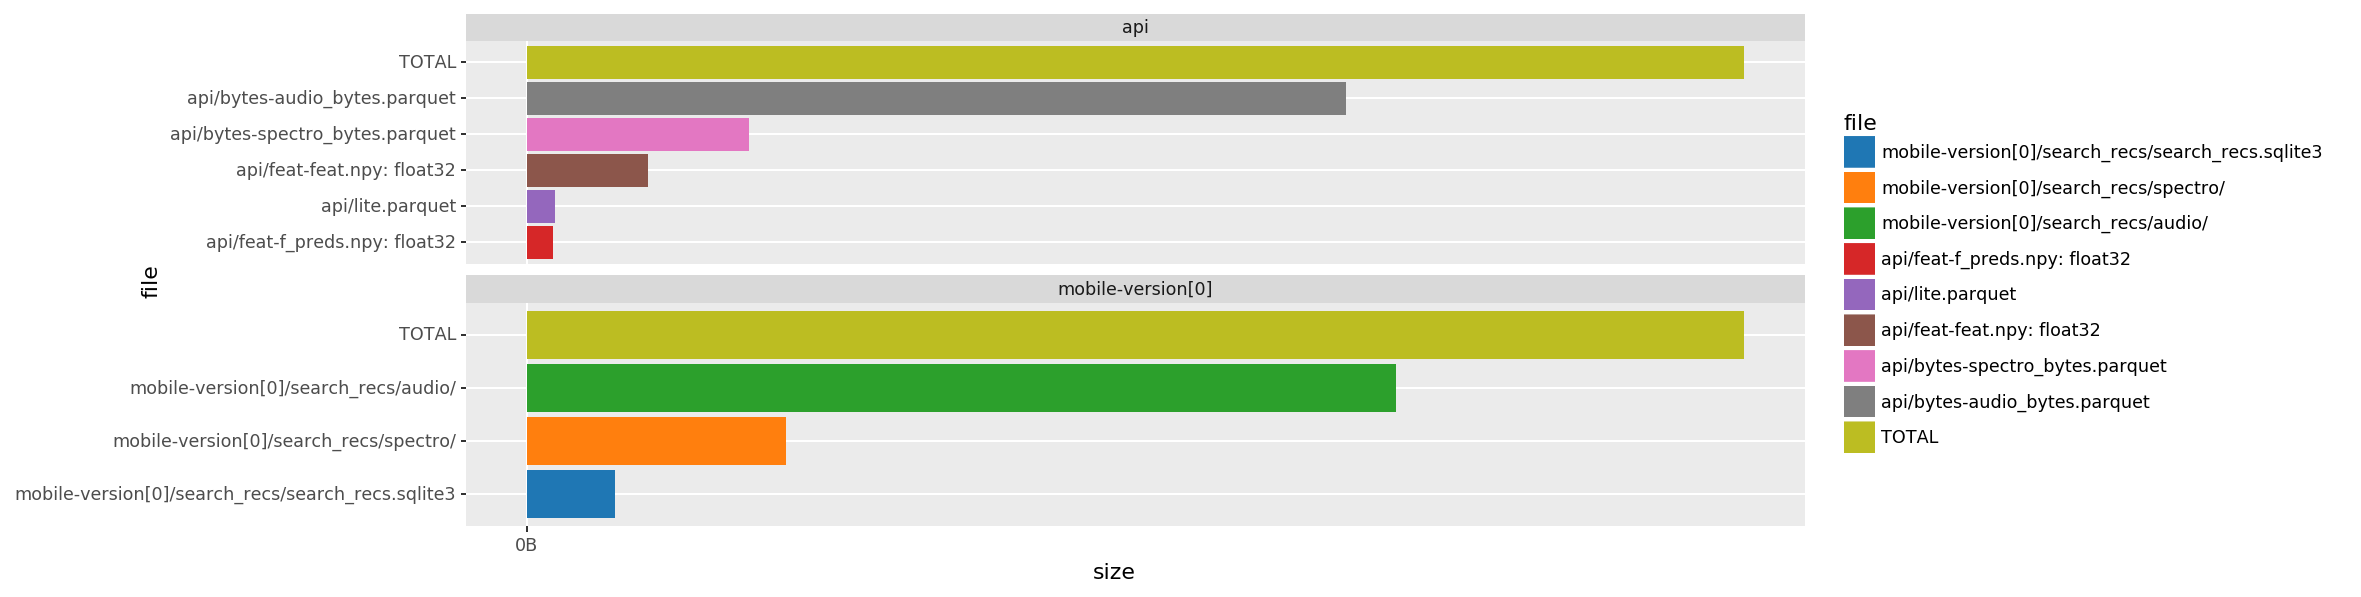

<ggplot: (325174399)>

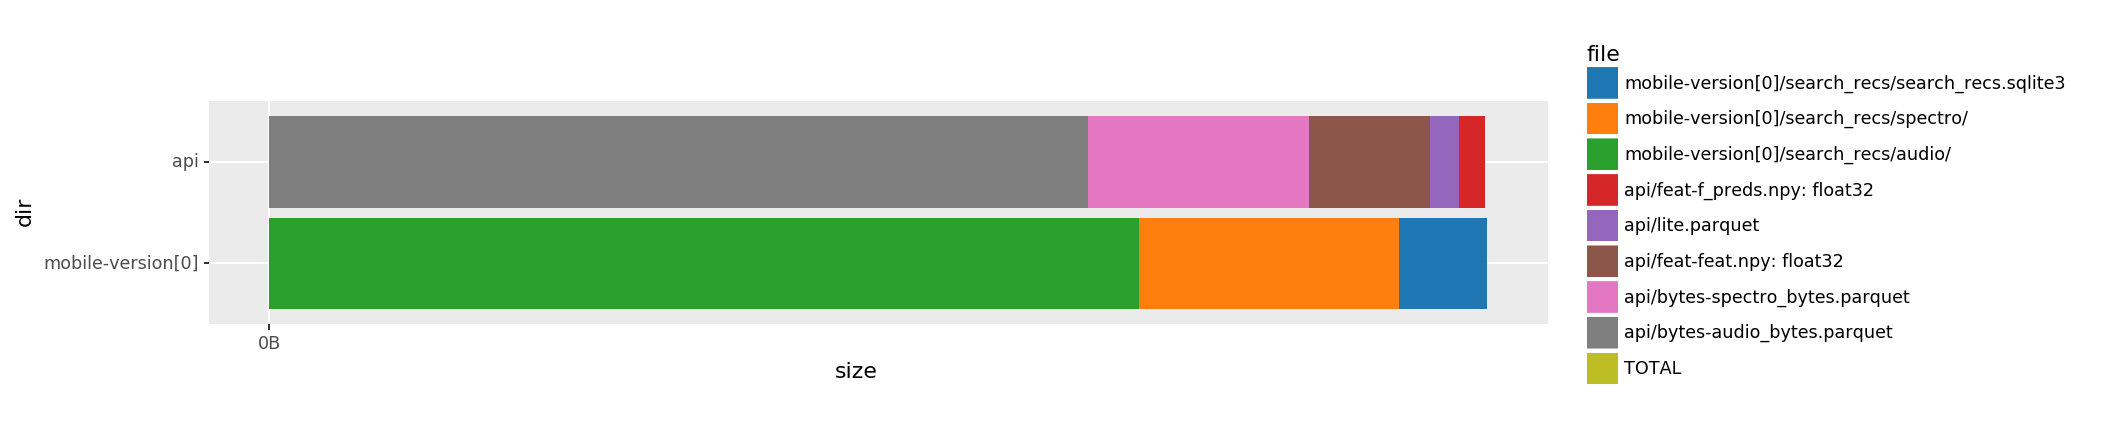

<ggplot: (325143777)>

,size,type,0
xc_id,36,int,413174
feat,6104,ndarray,[ 9.259e-02 -3.927e-02 4.972e-01 -4.154e-04 -4.900e-02 -6.117e-02 3.974e-02 -1.629e-01 6.649e-02 -1.643e-02 -8.081e-02 -7.604e-02 -9.098e-02 4.766e-02 -4.830e-02 -6.90...
f_preds,104,ndarray,[3.219e-03 1.693e-03 4.284e-05 3.685e-03 1.657e-03 1.457e-02 9.939e-03 1.444e-03 2.617e-04 6.943e-04 4.435e-04 7.072e-04 2.569e-03 9.745e-03 8.396e-04 2.003e-03 7.801e-04 ...
background,80,list,['White-crowned Sparrow (Zonotrichia leucophrys)']
background_species,80,list,['WCSP']


In [ ]:
log_levels({
    'payloads': 'INFO',
    # 'payloads': 'DEBUG',
})
kwargss = [
    # dict(cache_type='hybrid', refresh=True),  # Simulate cache miss
    dict(cache_type='hybrid'),                # Simulate cache hit
]
search_recss = []
for i, kwargs in enumerate(kwargss):
    if i > 0: print()
    print(f'search_recs(**{kwargs})')
    get_search_recs.cache_clear()
    search_recs = get_search_recs(**kwargs,
        write_mobile_payload=True,
        plot_sizes=True,
    )
    search_recss.append(search_recs)
    display(search_recs
        [['xc_id', 'feat', 'f_preds', 'background', 'background_species']]
        [2:3].reset_index(drop=True).T
        .pipe(df_assign_first,
            size=lambda df: df.T.memory_usage(deep=True),
            type=lambda df: df[0].map(lambda x: type(x).__name__),
        )
    )

In [ ]:
# TODO Turn this into unit tests
#   - Should roundtrip, should preserve category dtypes, should fail if index present
assert len(search_recss) == 2, "Test requires both 'cache hit' + 'cache miss' to be uncommented (above)"
[a, b] = search_recss
pd.testing.assert_frame_equal(a, b, check_column_type=True,
    check_index_type=False,  # Allow Int64Index vs. RangeIndex
)

[skip]